In [1]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import random_split, Dataset, DataLoader

import numpy as np

import random
# Set the random seed for reproducibility
seed = 45
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [73]:
# Reading train and test set

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(0,1)])

train_set = datasets.MNIST(
    root='PycharmProjects/pythonProject/data_download',
    train = True, transform=transform)

test_set = datasets.MNIST(
    root='PycharmProjects/pythonProject/data_download',
    train = False, transform=transform)

# Auto-Encoders for classification

3-1- Preprocessing

In [74]:
classes = train_set.targets.unique(return_counts=True)

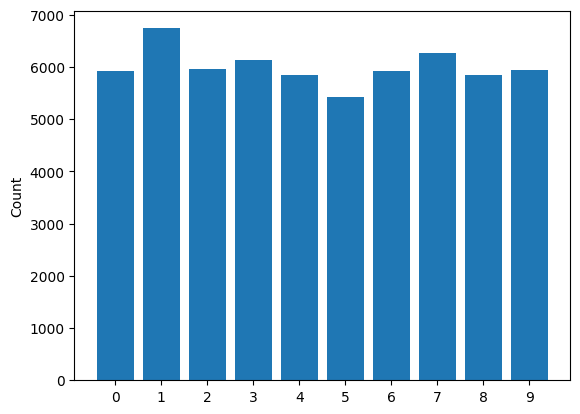

In [75]:
plt.bar(classes[0], classes[1])
plt.xticks(list(range(10)))
plt.ylabel('Count')
plt.show()

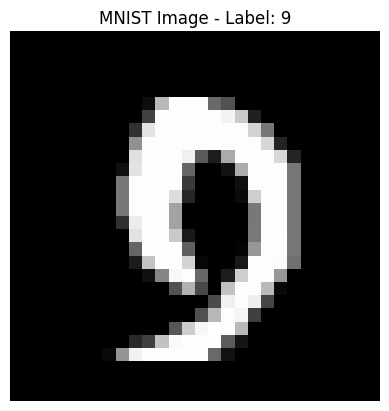

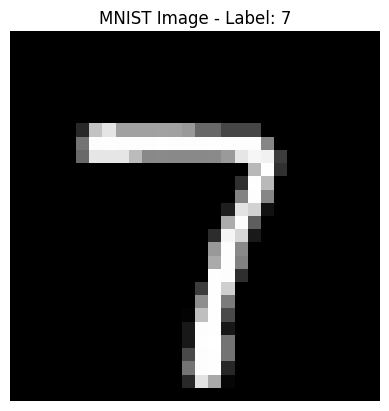

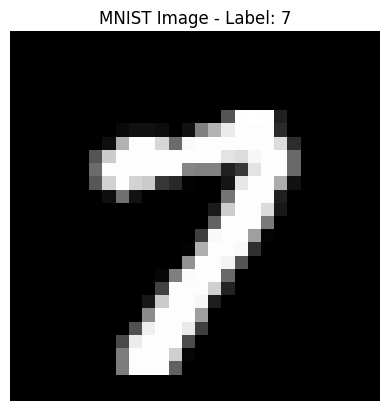

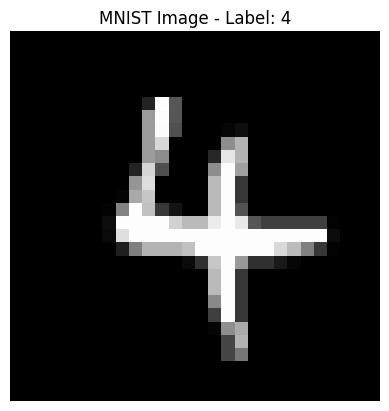

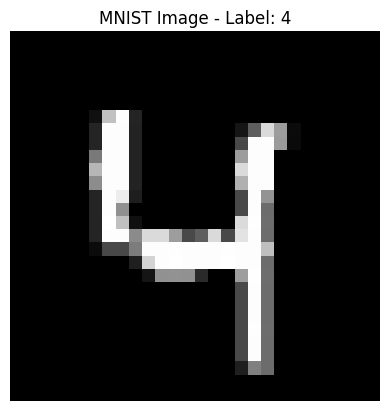

In [76]:
import random

random_numbers = [random.randint(0, train_set.data.size()[0]) for _ in range(5)]

for i in random_numbers:
    image, label = train_set.data[i], train_set.targets[i]

    if image.shape[0] == 1:
        image = image.squeeze()

    # Display the image
    plt.imshow(image, cmap='gray')
    plt.title(f"MNIST Image - Label: {label}")
    plt.axis('off')
    plt.show()


In [77]:
# Normalization

## Train-val split
train_set, val_set = random_split(train_set, [50000, 10000])

print(f"Size of the training set: {len(train_set)}")
print(f"Size of the validation set: {len(val_set)}")
print(f"Size of the test set: {len(test_set)}")

## Create the data loaders
train_loader = DataLoader(train_set, batch_size=256, shuffle=True)
val_loader = DataLoader(val_set, batch_size=256, shuffle=True)
test_loader = DataLoader(test_set, batch_size=256, shuffle=True)

Size of the training set: 50000
Size of the validation set: 10000
Size of the test set: 10000


3-2- Auto-Encoder

In [78]:
# Auto-Encoder class

class AE(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_input_layer = torch.nn.Linear(kwargs["input_shape"], 500)
        self.encoder_hidden_layer1 = torch.nn.Linear(500, 100)
        self.encoder_hidden_layer2 = torch.nn.Linear(100, 30)
        self.decoder_hidden_layer1 = torch.nn.Linear(30, 100)
        self.decoder_hidden_layer2 = torch.nn.Linear(100, 500)
        self.decoder_output_layer = torch.nn.Linear(500, kwargs["input_shape"])

    def forward(self, features):
        a2 = torch.relu(self.encoder_input_layer(features))
        a3 = torch.relu(self.encoder_hidden_layer1(a2))
        code = torch.relu(self.encoder_hidden_layer2(a3))
        a5 = torch.relu(self.decoder_hidden_layer1(code))
        a6 = torch.relu(self.decoder_hidden_layer2(a5))
        a7 = torch.relu(self.decoder_output_layer(a6))
        return a7

    def get_encoder(self, features):
        a1 = torch.relu(self.encoder_input_layer(features))
        a2 = torch.relu(self.encoder_hidden_layer1(a1))
        code = torch.relu(self.encoder_hidden_layer2(a2))
        return code


In [79]:
# Training the model by fitting to the data of the train_set
def fit(model, optimizer, train_loader, loss_function):
    train_loss = 0
    counter = 0
    model.train()

    for (image, _) in train_loader:
        counter+=1
        image = image.reshape(-1, 28*28)
        # The gradients are set to zero
        optimizer.zero_grad()
        # Output of Autoencoder
        reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        # add the mini-batch training loss to epoch loss
        train_loss += loss.item()
        # the gradient is computed and stored.
        loss.backward()
        # step() performs parameter update
        optimizer.step()


    train_loss = train_loss/counter
    return train_loss

In [80]:
# Validating data using the test set
def validation(model, val_loader, loss_function):
    validation_loss = 0
    counter = 0
    model.eval()

    for (image, _) in val_loader:
        counter+=1
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)
        # Output of Autoencoder
        reconstructed = model(image)
        # Calculating the loss function
        loss = loss_function(reconstructed, image)
        # add the mini-batch training loss to epoch loss
        validation_loss += loss.item()

    val_loss = validation_loss/counter
    return val_loss

In [81]:
# train and validate model to get loss values
def train(hparams, model, optimizer, train_loader, val_loader, loss_function):
    losses = []
    validation_losses = []

    for epoch in range(hparams['epochs']):
        train_loss = fit(model, optimizer, train_loader, loss_function)
        val_loss = validation(model, val_loader, loss_function)
        losses.append(train_loss)
        validation_losses.append(val_loss)

    return losses, validation_losses

In [82]:
# Model
hparams = {'batch_size': 256, 'lr': 2e-3, 'epochs': 10, 'input_shape': 784}
model = AE(input_shape=hparams['input_shape'])
# loss_function
loss_function = torch.nn.MSELoss()
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                         lr = hparams['lr'])

losses, validation_losses = train(hparams, model, optimizer, train_loader, val_loader, loss_function)

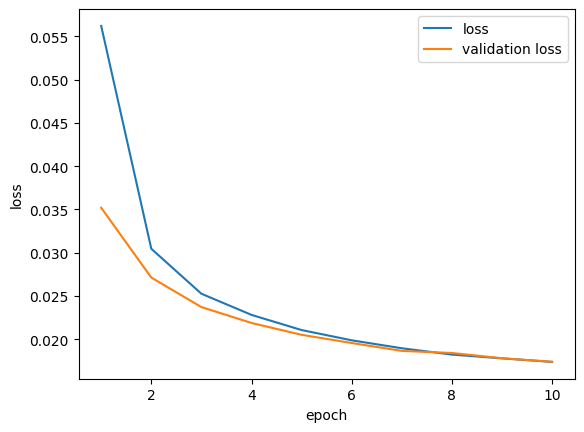

In [83]:
# plots for loss and validation loss
x = np.array(list(range(1,len(losses)+1)))
y1 = losses
y2 = validation_losses
plt.plot(x, y1, label='loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()


3-3- Calssification

In [84]:
# get encoder values as the new features
def get_encoder_features(model, loader):
    model.eval()
    # get codes for the dataset
    code = torch.empty(0,30)
    target = torch.empty(0)
    for (image, label) in loader:
        # Reshaping the image to (-1, 784)
        image = image.reshape(-1, 28*28)
        # Output of encoder
        x = model.get_encoder(image)
        code = torch.cat([x,code], dim=0)
        target = torch.cat([label,target], dim=0)

    return code, target

In [85]:
# get code for the train validation and test set and generate datasets
train_code, train_target = get_encoder_features(model, train_loader)
train_target = train_target.type(torch.LongTensor)
train_set_code = torch.utils.data.TensorDataset(train_code.detach(), train_target.detach())
# get code for the validation set
val_code, val_target = get_encoder_features(model, val_loader)
val_target = val_target.type(torch.LongTensor)
val_set_code = torch.utils.data.TensorDataset(val_code.detach(), val_target.detach())
# get code for the test set
test_code, test_target = get_encoder_features(model, test_loader)
test_target = test_target.type(torch.LongTensor)
test_set_code = torch.utils.data.TensorDataset(test_code.detach(), test_target.detach())

In [86]:
## Create the data loaders
train_loader_code = DataLoader(train_set_code, batch_size=256, shuffle=True)
val_loader_code = DataLoader(val_set_code, batch_size=256, shuffle=True)
test_loader_code = DataLoader(test_set_code, batch_size=256, shuffle=True)

In [87]:
# Fully-connected neural network
class FC(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.fc_input_layer = torch.nn.Linear(kwargs["input_shape"], kwargs["hidden_size1"])
        self.fc_hidden_layer1 = torch.nn.Linear(kwargs["hidden_size1"], kwargs["hidden_size2"])
        self.fc_hidden_layer2 = torch.nn.Linear(kwargs["hidden_size2"], kwargs["num_classes"])
        self.softm = torch.nn.Softmax(dim=1)

    def forward(self, features):
        a1 = torch.relu(self.fc_input_layer(features))
        a2 = torch.relu(self.fc_hidden_layer1(a1))
        a3 = self.fc_hidden_layer2(a2)
        return a3

In [88]:
# Training the model by fitting to the data of the train_set
def fit_fc(model, optimizer, train_loader, loss_function):
    train_loss = 0
    counter = 0
    correct = 0 # number of correct predictions
    total = 0
    model.train()

    for (image, target) in train_loader:
        counter+=1
        total += target.size(0)
        # The gradients are set to zero
        optimizer.zero_grad()
        # Output of Autoencoder
        outputs = model(image)
        # predict the class
        loss = loss_function(outputs, target)
        # add the mini-batch training loss to epoch loss
        train_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        correct += (preds == target).sum().item()
        # the gradient is computed and stored.
        loss.backward()
        # step() performs parameter update
        optimizer.step()


    train_loss = train_loss/counter
    train_accuracy = 100. * correct / total ## Mean epoch accuracy
    return train_loss, train_accuracy

In [89]:
# The method for evaluating the validation data
def validation_fc(model, data_loader, criterion):
    model.eval()    ## Evaluation mode (do not allow weight updates)
    val_loss = 0.0
    val_correct = 0
    counter = 0
    total = 0
    for (image, target) in data_loader:
        counter += 1
        total += target.size(0)
        outputs = model(image)
        loss = criterion(outputs, target)
        val_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_correct += (preds == target).sum().item()

    val_loss = val_loss / counter
    val_accuracy = 100. * val_correct / total
    return val_loss, val_accuracy

In [90]:
# train and validate model to get loss values
def train_fc(hparams, model, optimizer, train_loader, val_loader, loss_function):
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(hparams['epochs']):
        train_loss, train_accuracy = fit_fc(model, optimizer, train_loader, loss_function)
        val_loss, val_accuracy = validation_fc(model, val_loader, loss_function)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_accuracy)

    return train_losses, train_accuracies, validation_losses, validation_accuracies

In [91]:
# Model
hparams = {'batch_size': 256, 'lr': 1e-3, 'epochs': 25, 'input_shape': 30}
model = FC(input_shape = 30, hidden_size1 = 128, hidden_size2 = 128, num_classes = 10)
# loss_function
loss_function = torch.nn.CrossEntropyLoss()
# Using an Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(),
                         lr = hparams['lr'])
train_losses, train_accuracy, validation_losses, validation_accuracy = train_fc(hparams, model, optimizer, train_loader_code, val_loader_code, loss_function)

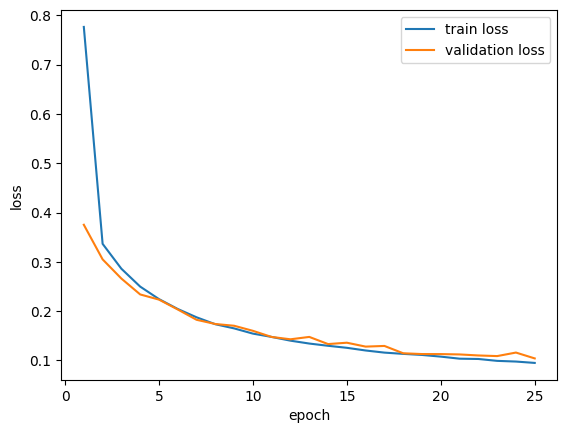

In [92]:
# plots for loss and validation loss
x = np.array(list(range(1,len(train_losses)+1)))
y1 = train_losses
y2 = validation_losses
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

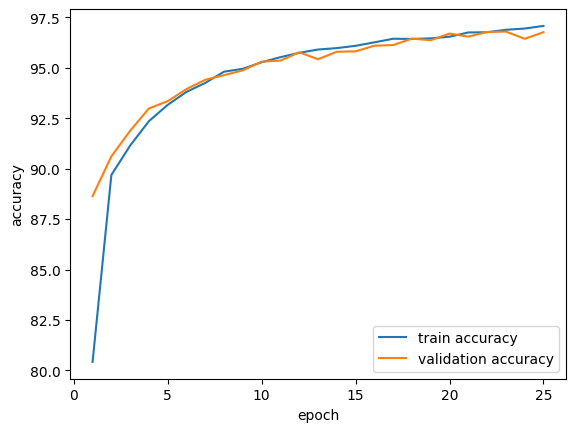

In [93]:
# plots for loss and validation accuracy
x = np.array(list(range(1,len(train_accuracy)+1)))
y1 = train_accuracy
y2 = validation_accuracy
plt.plot(x, y1, label='train accuracy')
plt.plot(x, y2, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()

saving and loading the model

In [94]:
# Saving the model
torch.save(model.state_dict(), 'saved_model')
# loading the model
model.load_state_dict(torch.load('saved_model'))

<All keys matched successfully>

In [95]:
model.eval()
test_loss, test_accuracy = validation_fc(model, test_loader_code, loss_function)
print("Test accuracy: ", test_accuracy)

Test accuracy:  96.85


confusion matrix

In [96]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [97]:
## Utility method to plot a confusion matrix (cm) given the sklearn cm object and the class names
import itertools

def plot_confusion_matrix(cm, target_names, title, normalize):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.2f}; misclass={:0.2f}'.format(accuracy, misclass))
    plt.show()

In [98]:
import copy

## Main post-processing method
def detailed_analysis(model, n_classes, class_names, train_loader,\
                      test_loader, train_accuracy, train_loss, val_accuracy, val_loss):
    model.eval()  # No training in post-processing

    ### Train
    loader = train_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_train = [0.] * n_classes
    y_true = []
    y_pred = []
    # No grad calculations needed in post-processing
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)    ## For calculating class-wise accuracies
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
                class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_train[i] = class_corrects[i]/class_totals[i]   ## Class-wise accuracies

    cm_train = confusion_matrix(y_true, y_pred)   ## Sklearn confusion matrix object
    y_true_train = copy.deepcopy(y_true)
    y_pred_train = copy.deepcopy(y_pred)

    ### Test
    loader = test_loader
    correct = 0.
    total = 0.
    class_corrects = [0.] * n_classes
    class_totals = [0.] * n_classes
    class_accs_test = [0.] * n_classes
    y_true = []
    y_pred = []
    with torch.no_grad():
      for images, labels in loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to('cpu') == labels).sum().item()
        Bool = (predicted.to('cpu') == labels)
        y_pred.extend(list(predicted.to('cpu').numpy()))
        y_true.extend(list(labels.numpy()))
        for i in range(len(images)):
            class_totals[labels[i]] += 1
            if Bool[i] == True:
              class_corrects[labels[i]] += 1
    for i in range(n_classes):
      class_accs_test[i] = class_corrects[i]/class_totals[i]
    cm_test = confusion_matrix(y_true, y_pred)
    y_true_test = copy.deepcopy(y_true)
    y_pred_test = copy.deepcopy(y_pred)

    ## Plots
    fig, axs = plt.subplots(3, figsize=(30,20))
    axs[0].plot(list(range(1,len(train_loss)+1)), train_loss, label='Train Loss')
    axs[0].plot(list(range(1,len(val_loss)+1)), val_loss, label='Val Loss')
    axs[0].set_title('Loss per Epoch')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(list(range(1,len(train_accuracy)+1)), train_accuracy, label='Train Acc')
    axs[1].plot(list(range(1,len(val_accuracy)+1)), val_accuracy, label='Val Acc')
    axs[1].set_title('Acc per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Acc')
    axs[1].legend()

    x = np.arange(len(class_names))
    width = 0.2
    trains = axs[2].bar(x, class_accs_train, width, label='Train')
    tests = axs[2].bar(x + width, class_accs_test, width, label = 'Test')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_title('Final Accuracy of Each Class (Train and Test)')
    axs[2].set_xticks(x+width/2)
    axs[2].set_xticklabels(class_names)
    axs[2].legend()
    plt.show()

    return cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test

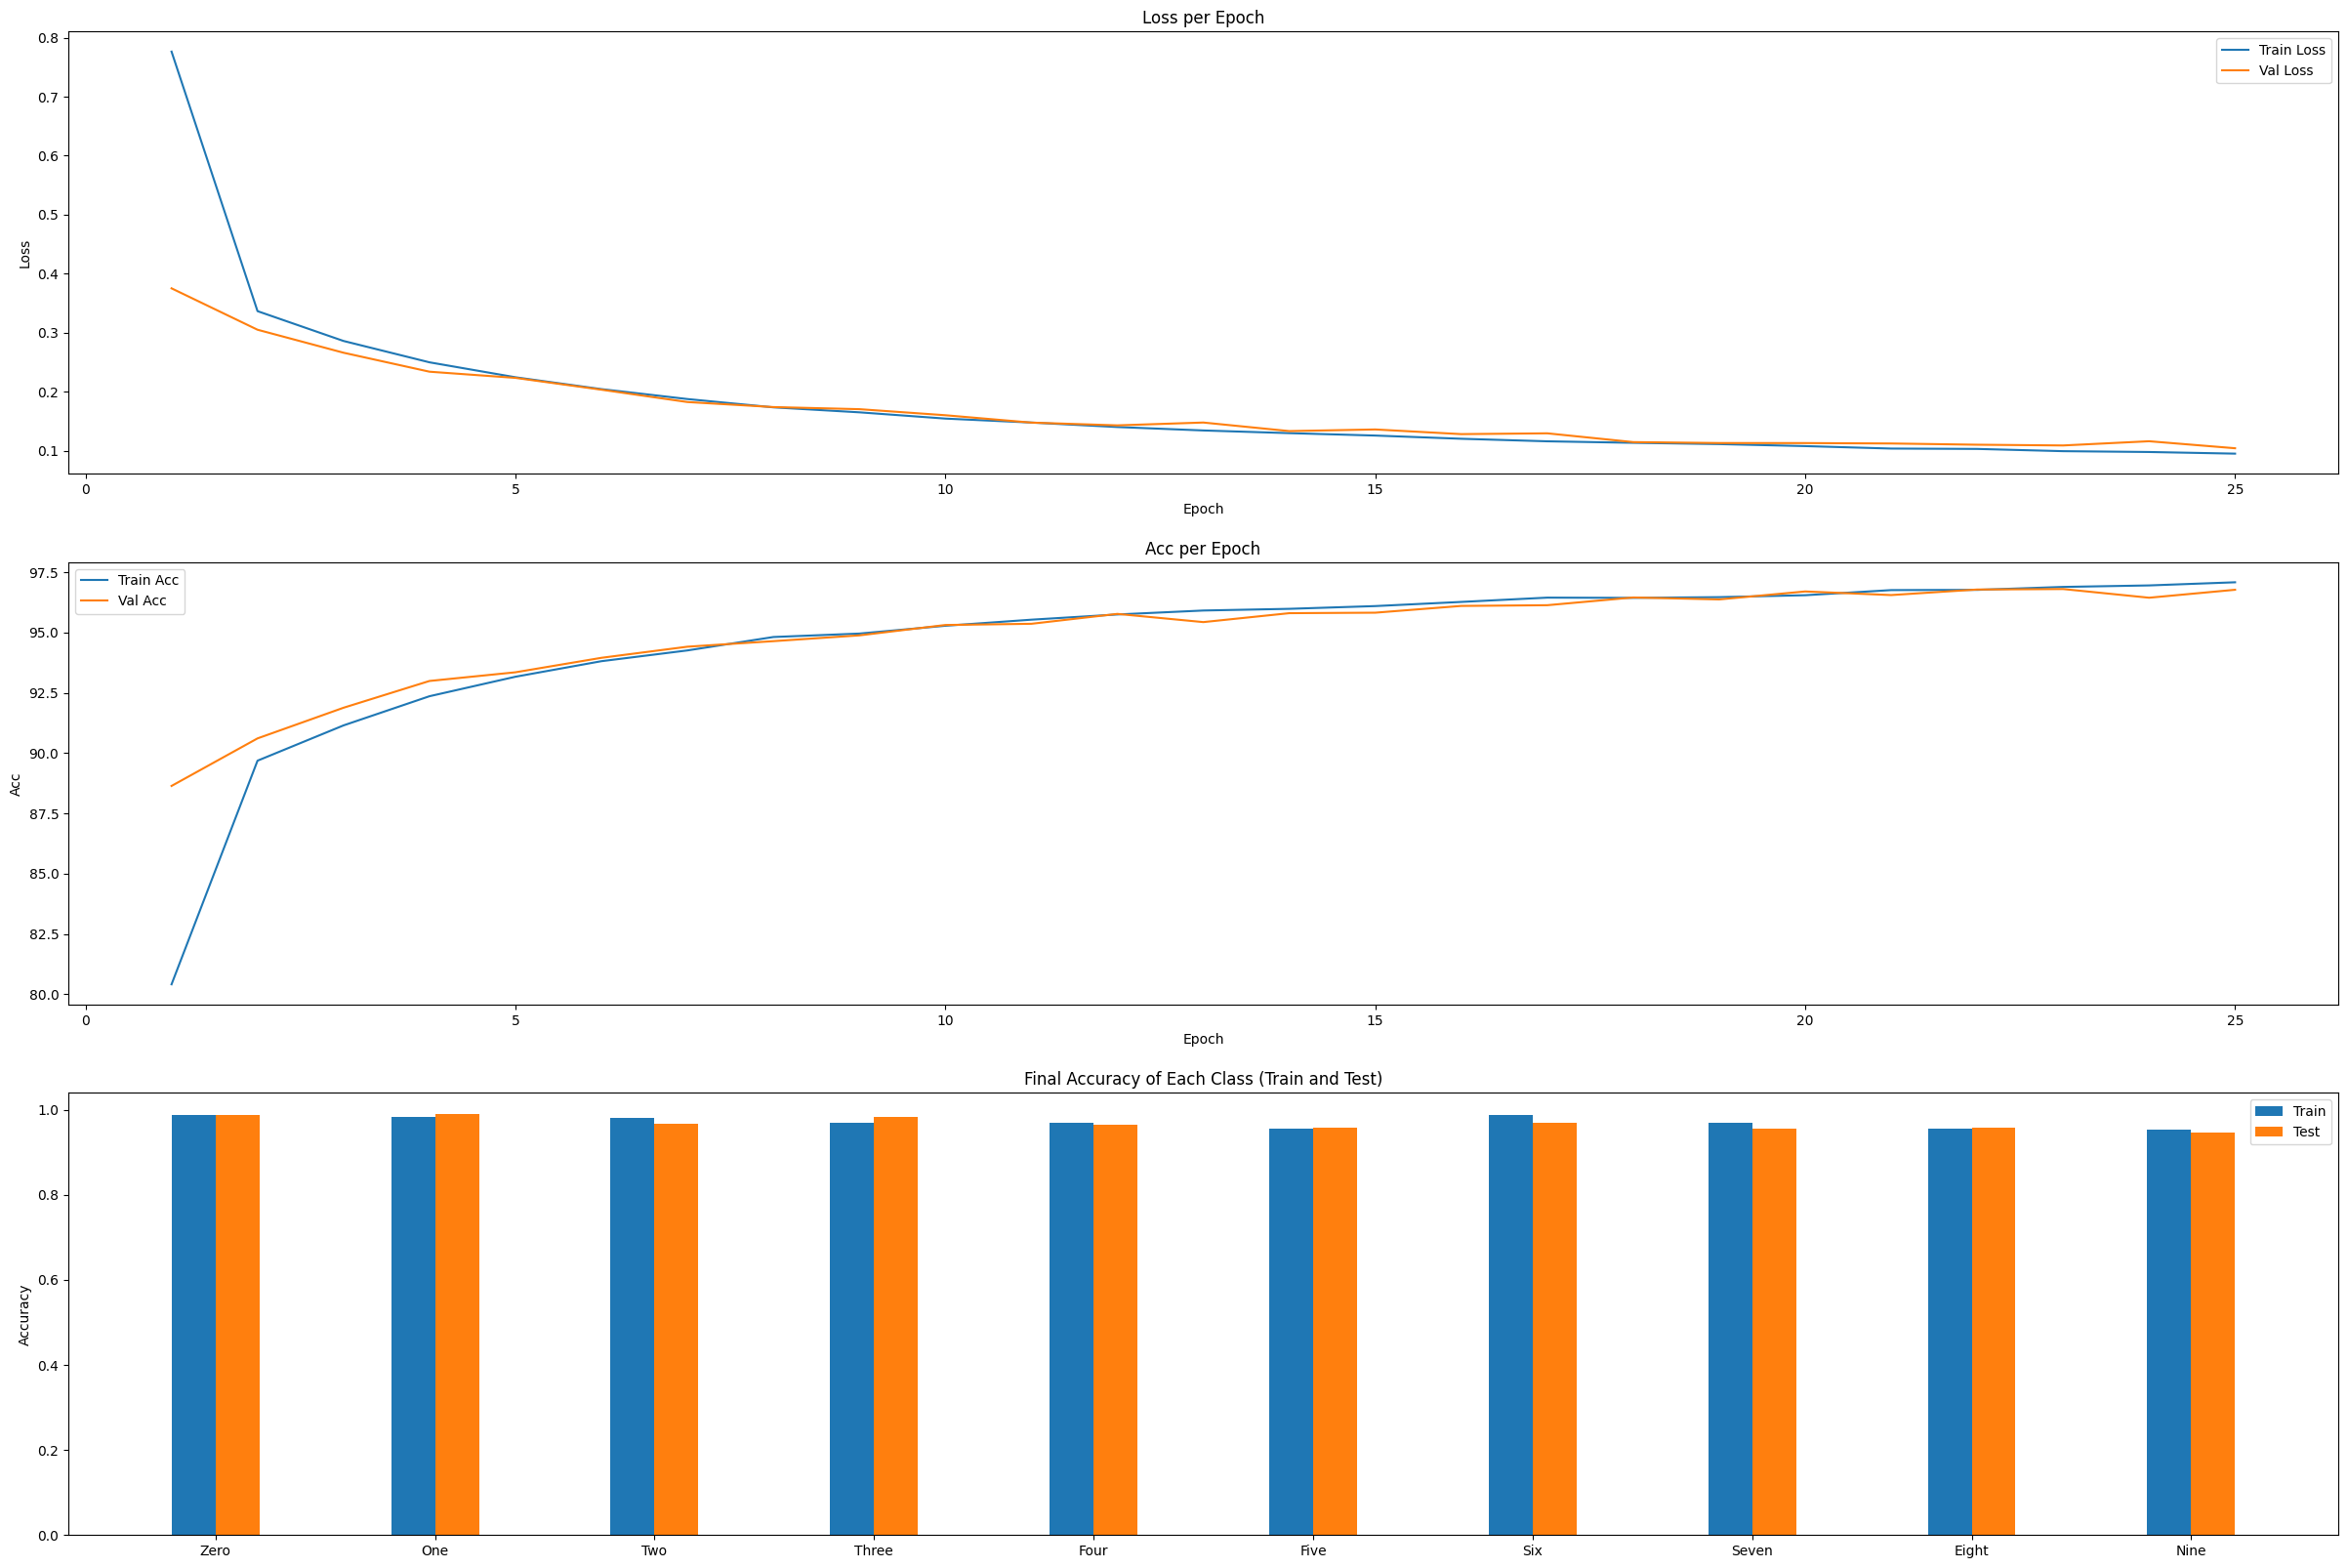

In [99]:
class_names = ["Zero","One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]
cm_train, cm_test, y_true_train, y_pred_train, y_true_test, y_pred_test = detailed_analysis(model,\
                                                        10, class_names, train_loader_code, test_loader_code,\
                                                         train_accuracy, train_losses, validation_accuracy, validation_losses)    ## Post-processing

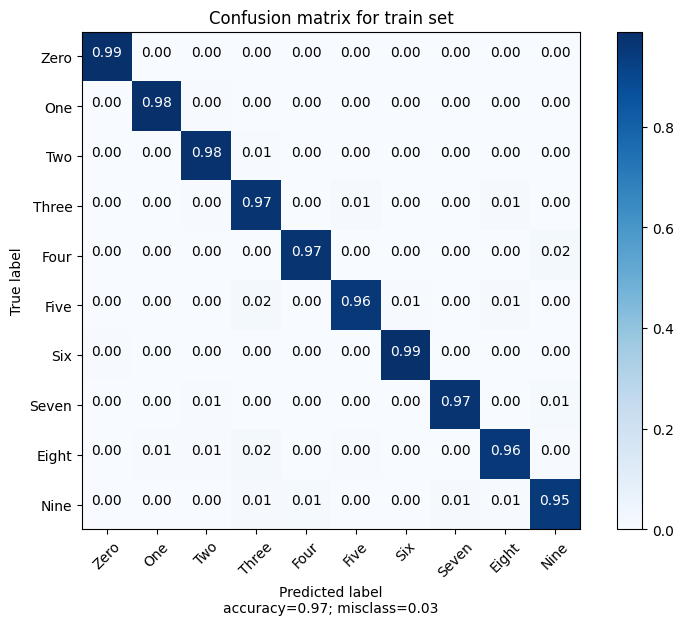

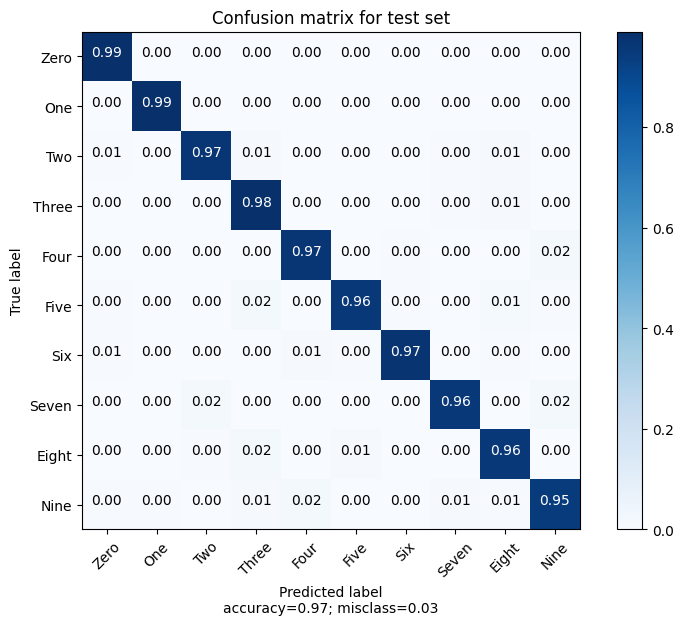

In [100]:
plot_confusion_matrix(cm_train, class_names, title='Confusion matrix for train set', normalize=True)
print()
plot_confusion_matrix(cm_test, class_names, title='Confusion matrix for test set', normalize=True)

# Multi-Layer Perceptron

### Preprocessing
1-1- Reading the dataset and getting the info

In [2]:
# Set the random seed for reproducibility
seed = 45
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

import pandas as pd
df = pd.read_csv('CarPrice_Assignment.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

1-2- Nan values for each feature

In [3]:
df.isna().sum()

car_ID              0
symboling           0
CarName             0
fueltype            0
aspiration          0
doornumber          0
carbody             0
drivewheel          0
enginelocation      0
wheelbase           0
carlength           0
carwidth            0
carheight           0
curbweight          0
enginetype          0
cylindernumber      0
enginesize          0
fuelsystem          0
boreratio           0
stroke              0
compressionratio    0
horsepower          0
peakrpm             0
citympg             0
highwaympg          0
price               0
dtype: int64

1-3- Extracting company name and cleaning data

In [4]:
# Extracting company names
df['CompanyName'] = df['CarName'].apply(lambda x: x.split()[0])

In [5]:
# dropping unuseful columns
df = df.drop(columns=['CarName', 'car_ID', 'symboling'])

In [6]:
# finding misspelled company names
df['CompanyName'].unique()
# maxda, Nissan, porcshce, toyouta, vokswagen, vw

array(['alfa-romero', 'audi', 'bmw', 'chevrolet', 'dodge', 'honda',
       'isuzu', 'jaguar', 'maxda', 'mazda', 'buick', 'mercury',
       'mitsubishi', 'Nissan', 'nissan', 'peugeot', 'plymouth', 'porsche',
       'porcshce', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'vokswagen', 'volkswagen', 'vw', 'volvo'], dtype=object)

In [7]:
df = df.replace({'CompanyName': {'maxda': 'mazda', 'Nissan': 'nissan', 'porcshce': 'porsche', 'toyouta': 'toyota', 'vokswagen': 'volkswagen', 'vw': 'volkswagen'}})

1-4- changing categorical features to dummy variables

In [8]:
df = pd.get_dummies(df, drop_first=False)

1-5- Correlation matrix

In [9]:
# engine size is the most correlated to price
df.corr()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,CompanyName_nissan,CompanyName_peugeot,CompanyName_plymouth,CompanyName_porsche,CompanyName_renault,CompanyName_saab,CompanyName_subaru,CompanyName_toyota,CompanyName_volkswagen,CompanyName_volvo
wheelbase,1.000000,0.874587,0.795144,0.589435,0.776386,0.569329,0.488750,0.160959,0.249786,0.353294,...,-0.156719,0.453616,-0.105511,-0.170472,-0.043896,0.009927,-0.107161,-0.046785,-0.047664,0.306228
carlength,0.874587,1.000000,0.841118,0.491029,0.877728,0.683360,0.606454,0.129533,0.158414,0.552623,...,-0.077149,0.330602,-0.139780,-0.048682,0.041138,0.177076,-0.105172,-0.073906,-0.030714,0.285398
carwidth,0.795144,0.841118,1.000000,0.279210,0.867032,0.735433,0.559150,0.182942,0.181129,0.640732,...,-0.118727,0.276302,-0.143778,0.089564,0.029787,0.048052,-0.111605,-0.164234,-0.033924,0.228758
carheight,0.589435,0.491029,0.279210,1.000000,0.295572,0.067149,0.171071,-0.055307,0.261214,-0.108802,...,-0.011652,0.337701,-0.135256,-0.170265,-0.035625,0.169192,0.002570,-0.000530,0.149194,0.245342
curbweight,0.776386,0.877728,0.867032,0.295572,1.000000,0.850594,0.648480,0.168790,0.151362,0.750739,...,-0.092690,0.305064,-0.121164,0.102171,-0.006892,0.063495,-0.114888,-0.094786,-0.101966,0.221127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CompanyName_saab,0.009927,0.177076,0.048052,0.169192,0.063495,-0.024692,0.028006,-0.195426,-0.041231,0.099258,...,-0.053872,-0.041347,-0.032649,-0.027455,-0.017235,1.000000,-0.043297,-0.074679,-0.043297,-0.041347
CompanyName_subaru,-0.107161,-0.105172,-0.111605,0.002570,-0.114888,-0.118994,0.267866,-0.509133,-0.083437,-0.112939,...,-0.077362,-0.059376,-0.046884,-0.039426,-0.024750,-0.043297,1.000000,-0.107242,-0.062176,-0.059376
CompanyName_toyota,-0.046785,-0.073906,-0.164234,-0.000530,-0.094786,-0.083807,-0.079203,-0.000570,0.021501,-0.123590,...,-0.133434,-0.102411,-0.080866,-0.068002,-0.042689,-0.074679,-0.107242,1.000000,-0.107242,-0.102411
CompanyName_volkswagen,-0.047664,-0.030714,-0.033924,0.149194,-0.101966,-0.117994,-0.184355,0.115246,0.219153,-0.145598,...,-0.077362,-0.059376,-0.046884,-0.039426,-0.024750,-0.043297,-0.062176,-0.107242,1.000000,-0.059376


1-6- Data visualization

(array([83., 45., 35., 18.,  6.,  3.,  5.,  7.,  2.,  1.]),
 array([ 5118. ,  9146.2, 13174.4, 17202.6, 21230.8, 25259. , 29287.2,
        33315.4, 37343.6, 41371.8, 45400. ]),
 <BarContainer object of 10 artists>)

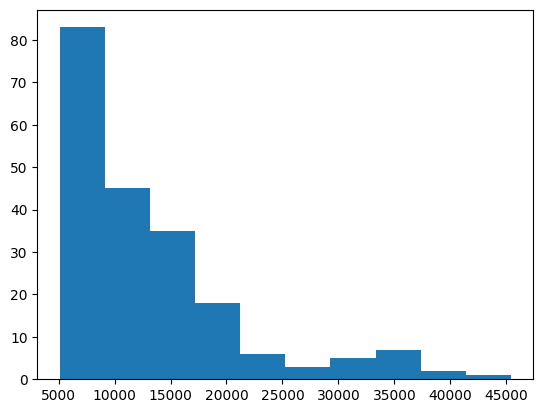

In [10]:
# distribution of price
plt.hist(df['price'])

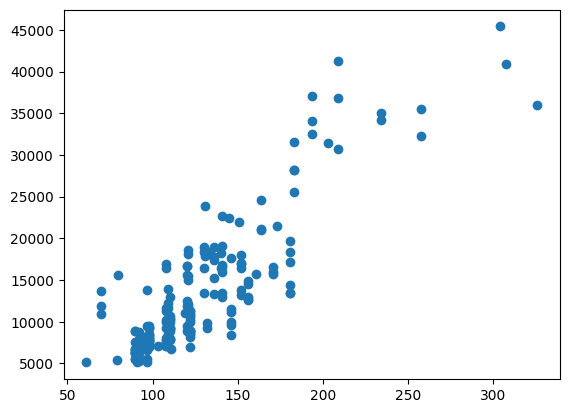

In [11]:
# scatter plot: engine size vs price
plt.scatter(df['enginesize'], df['price'])

1-7- split data to train and test

In [12]:
from sklearn.model_selection import train_test_split

target = df['price']
features = df.drop(columns=['price'])
train_features, test_features, train_labels, test_labels = train_test_split(features, target, test_size=0.15, random_state=42, shuffle=True)

1-8- Scaling data

In [13]:
# minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# scale features
scaler.fit(train_features)
train_features_scaled = pd.DataFrame(scaler.transform(train_features), columns = train_features.columns)
test_features_scaled = pd.DataFrame(scaler.transform(test_features), columns = test_features.columns)
# scale target
target_scaler = MinMaxScaler()
target_scaler.fit(train_labels.values.reshape(-1, 1))
train_labels_scaled = pd.DataFrame(target_scaler.transform(train_labels.values.reshape(-1, 1)))
test_labels_scaled = pd.DataFrame(target_scaler.transform(test_labels.values.reshape(-1, 1)))

### 2- Training
Generating train, validation, and test loaders

In [14]:
# generating data loaders
train = torch.utils.data.TensorDataset(torch.Tensor(np.array(train_features_scaled)).detach(), torch.Tensor(np.array(train_labels_scaled.values)).detach())
test = torch.utils.data.TensorDataset(torch.Tensor(np.array(test_features_scaled)).detach(), torch.Tensor(np.array(test_labels_scaled.values)).detach())

## Train-val split
train, val = random_split(train, [145, 29])

# Create the data loaders
train_loader = DataLoader(train, batch_size=len(train), shuffle=True)
val_loader = DataLoader(val, batch_size=len(val), shuffle=True)
test_loader = DataLoader(test, batch_size=len(test), shuffle=True)

2-1- Building dynamic MLP class

In [15]:
# MLP neural network
class DynamicMLP(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        # input layer
        self.layers = torch.nn.ModuleList([torch.nn.Linear(kwargs["input_shape"], kwargs["hidden_size"][0])])
        for i in range(len(kwargs["hidden_size"])-1):
            self.layers.append(torch.nn.Linear(kwargs["hidden_size"][i], kwargs["hidden_size"][i+1]))
        # output layer
        self.layers.append(torch.nn.Linear(kwargs["hidden_size"][len(kwargs["hidden_size"])-1], kwargs["output_shape"]))

    def forward(self, features):
        x = self.layers[0](features)
        for layer in self.layers[1:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)

        return x

In [16]:
# Training the model by fitting to the data of the train_set
def fit_mlp(model, optimizer, train_loader, loss_function):
    train_loss = 0
    model.train()

    for (row, target) in train_loader:
        # The gradients are set to zero
        optimizer.zero_grad()
        # Output of trainer
        output = model(row)
        # Calculating the loss function
        loss = loss_function(output, target)
        # add the mini-batch training loss to epoch loss
        train_loss += loss.item()
        # the gradient is computed and stored.
        loss.backward()
        # step() performs parameter update
        optimizer.step()
    return train_loss


# Validating data using the test set
def validation_mlp(model, val_loader, loss_function):
    validation_loss = 0
    model.eval()

    for (row, target) in val_loader:
        # Output of model
        output = model(row)
        # Calculating the loss function
        loss = loss_function(output, target)
        # add the mini-batch training loss to epoch loss
        validation_loss += loss.item()

    return validation_loss


# train and validate model to get loss values
def train_mlp(hparams, model, optimizer, train_loader, val_loader, loss_function):
    losses = []
    validation_losses = []

    for epoch in range(hparams['epochs']):
        train_loss = fit_mlp(model, optimizer, train_loader, loss_function)
        val_loss = validation_mlp(model, val_loader, loss_function)
        losses.append(train_loss)
        validation_losses.append(val_loss)

    return losses, validation_losses

2-2- loss functions and oprimizers
loss functions:
criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.L1Loss()

optimizers:
optimizer1 = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer2 = torch.optim.SGD(model.parameters(), lr=learning_rate)

2-3- Using criterion 1 and optimizer1 to train 3 MLPs with 1, 2, and 3 hidden layers

In [17]:
# Model 1: 1 hidden layer, adam optimizer, MSELoss
hparams1 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 25}
# loss_function
loss_function1 = torch.nn.MSELoss()
model1 = DynamicMLP(input_shape = 73, hidden_size = [73], output_shape = 1)
# Using an Adam Optimizer
optimizer1 = torch.optim.Adam(model1.parameters(), lr = hparams1['lr'])
train_losses1, validation_losses1 = train_mlp(hparams1, model1, optimizer1, train_loader, val_loader, loss_function1)

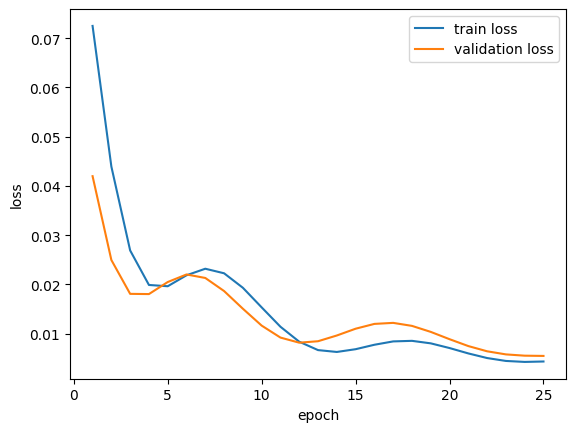

In [18]:
# plots for loss and validation loss
x = np.array(list(range(1,len(train_losses1)+1)))
y1 = train_losses1
y2 = validation_losses1
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [19]:
# Model 2: 2 hidden layers, adam optimizer, MSELoss
hparams2 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 25}
model2 = DynamicMLP(input_shape = 73, hidden_size = [73,73], output_shape = 1)
# loss_function
loss_function2 = torch.nn.MSELoss()
# Using an Adam Optimizer
optimizer2 = torch.optim.Adam(model2.parameters(), lr = hparams2['lr'])
train_losses2, validation_losses2 = train_mlp(hparams2, model2, optimizer2, train_loader, val_loader, loss_function2)

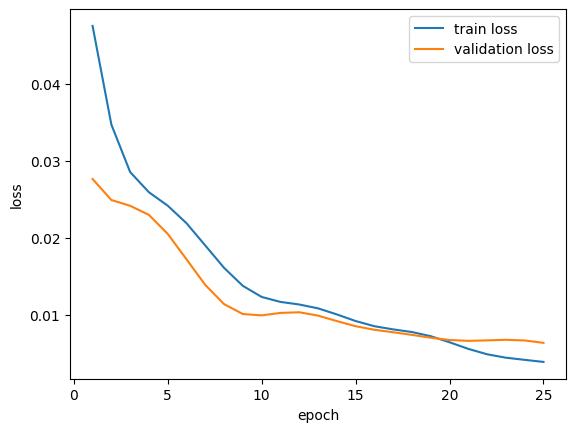

In [20]:
# plots for loss and validation loss
x = np.array(list(range(1,len(train_losses2)+1)))
y1 = train_losses2
y2 = validation_losses2
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [21]:
# Model 3: 3 hidden layers, adam optimizer, MSELoss
hparams3 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 40}
model3 = DynamicMLP(input_shape = 73, hidden_size = [73,73,73], output_shape = 1)
# loss_function
loss_function3 = torch.nn.MSELoss()
# Using an Adam Optimizer
optimizer3 = torch.optim.Adam(model3.parameters(), lr = hparams3['lr'])
train_losses3, validation_losses3 = train_mlp(hparams3, model3, optimizer3, train_loader, val_loader, loss_function3)

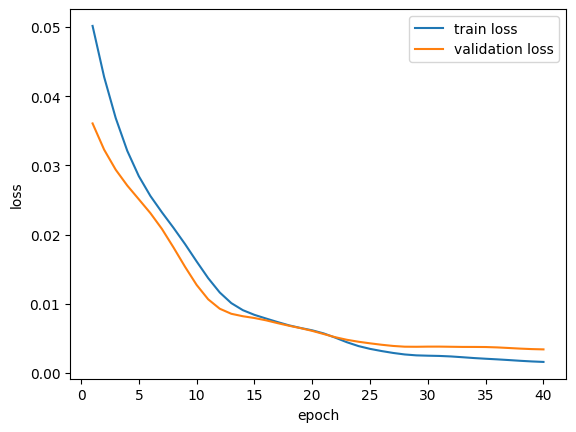

In [22]:
# plots for loss and validation loss
x = np.array(list(range(1,len(train_losses3)+1)))
y1 = train_losses3
y2 = validation_losses3
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

**R2Score**
R2 score is a value between -∞ and 1, and it represents the proportion of the variance in the dependent variable (target) that is explained by the independent variables (features) in the model. It measures the goodness-of-fit of the model by comparing it to a simple baseline model, often the mean of the target variable.

In [23]:
def predict(model, loader):
    model.eval()
    predicted_target = torch.empty(0)
    actual_target = torch.empty(0)
    for (row, targets) in loader:
        # Output of model
        output = model(row)
        predicted_target = torch.cat([output,predicted_target], dim=0)
        actual_target = torch.cat([targets,actual_target], dim=0)
    return predicted_target, actual_target

In [24]:
from torcheval.metrics import R2Score
# get R2Score
def get_R2(model, loader):
    predicted_target, actual_target = predict(model, loader)

    metric = R2Score()
    metric.update(predicted_target, actual_target)
    return metric.compute()

In [25]:
print("model 1: ", get_R2(model1, val_loader), "model 2: ", get_R2(model2, val_loader), "model 3: ", get_R2(model3, val_loader))

model 1:  tensor(0.8453) model 2:  tensor(0.8214) model 3:  tensor(0.9042)


**Result:** Model 3, with 3 hidden layers, is the best model.

2-4- Evaluating other criterion and optimizers

2-4-1- L1Loss and Adam

In [26]:
hparams31 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 40}
model31 = DynamicMLP(input_shape = 73, hidden_size = [73,73,73], output_shape = 1)
# loss_function
loss_function31 = torch.nn.L1Loss()
# Using an Adam Optimizer
optimizer31 = torch.optim.Adam(model31.parameters(), lr=hparams31['lr'])
train_losses31, validation_losses31 = train_mlp(hparams31, model31, optimizer31, train_loader, val_loader, loss_function31)

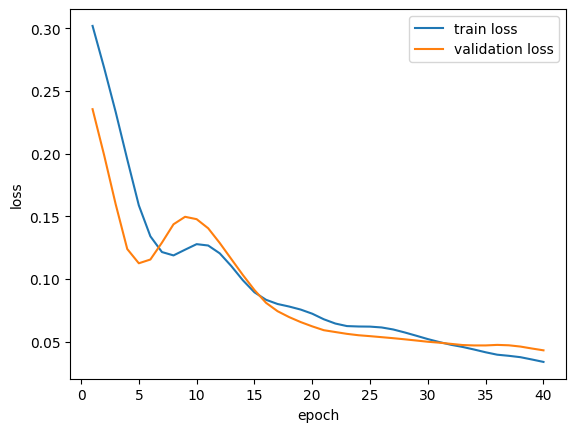

In [27]:
# plots for loss and validation loss
x = np.array(list(range(1, len(train_losses31) + 1)))
y1 = train_losses31
y2 = validation_losses31
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [28]:
print("model 3-1: ", get_R2(model31, val_loader))

model 3-1:  tensor(0.8849)


2-4-2- MSELoss and SGD

In [29]:
hparams32 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 32}
model32 = DynamicMLP(input_shape = 73, hidden_size = [73,73,73], output_shape = 1)
# loss_function
loss_function32 = torch.nn.L1Loss()
# Using an Adam Optimizer
optimizer32 = torch.optim.Adam(model32.parameters(), lr=hparams32['lr'])
train_losses32, validation_losses32 = train_mlp(hparams32, model32, optimizer32, train_loader, val_loader, loss_function32)

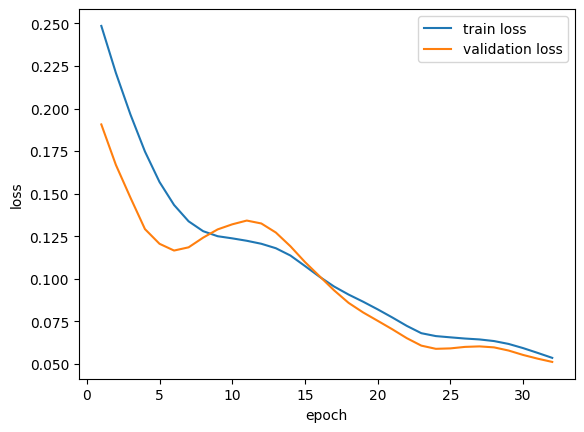

In [30]:
# plots for loss and validation loss
x = np.array(list(range(1, len(train_losses32) + 1)))
y1 = train_losses32
y2 = validation_losses32
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [31]:
print("model 3-2: ", get_R2(model32, val_loader))

model 3-2:  tensor(0.8033)


2-4-3- L1Loss and SGD

In [32]:
hparams33 = {'batch_size': len(train), 'lr': 1e-3, 'epochs': 50}
model33 = DynamicMLP(input_shape = 73, hidden_size = [73,73,73], output_shape = 1)
# loss_function
loss_function33 = torch.nn.L1Loss()
# Using an Adam Optimizer
optimizer33 = torch.optim.Adam(model33.parameters(), lr=hparams33['lr'])
train_losses33, validation_losses33 = train_mlp(hparams33, model33, optimizer33, train_loader, val_loader, loss_function33)

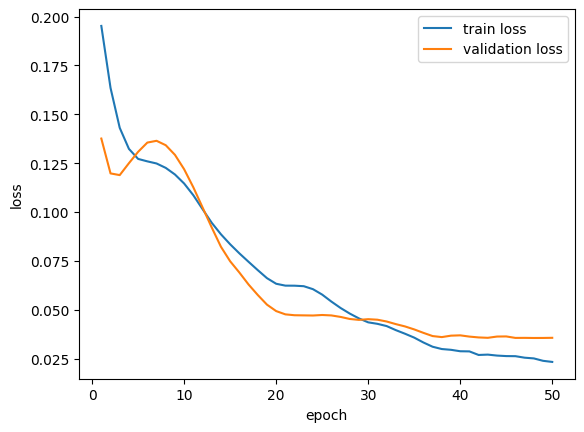

In [33]:
# plots for loss and validation loss
x = np.array(list(range(1, len(train_losses33) + 1)))
y1 = train_losses33
y2 = validation_losses33
plt.plot(x, y1, label='train loss')
plt.plot(x, y2, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

In [34]:
print("model 3-3: ", get_R2(model33, val_loader))

model 3-3:  tensor(0.9156)


**Result:** model 3-3 with L1 Loss and SGD optimizer has the best R2 score.

2-5- Price prediction

In [35]:
test_subset, _ = random_split(test, [5, len(test)-5])

In [36]:
predicted_target, actual_target = predict(model33, test_subset)
r2score = get_R2(model33, test_subset)
print("R2Score: ", r2score, "predicted price: ", target_scaler.inverse_transform(predicted_target.detach().numpy().reshape(-1, 1)), "\n actual price: ", target_scaler.inverse_transform(actual_target.detach().numpy().reshape(-1, 1)), "\n difference: ", ((predicted_target-actual_target).detach().numpy())*(target_scaler.data_max_-target_scaler.data_min_))

R2Score:  tensor(0.8115) predicted price:  [[ 5950.2495]
 [26900.393 ]
 [15986.275 ]
 [ 9356.453 ]
 [37284.83  ]] 
 actual price:  [[ 5151.   ]
 [41315.   ]
 [18280.   ]
 [ 8495.   ]
 [40959.996]] 
 difference:  [   799.24996075 -14414.60938454  -2293.72507846    861.45304532
  -3675.17076337]


In [37]:
print("R2 score for the whole test set: ", get_R2(model33, test))

R2 score for the whole test set:  tensor(0.8796)
